In [109]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

import random

In [110]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# data processing

In [111]:
# same as sklearn 
df = pd.read_csv("data/allHorizonData_cut.csv")

seq_features = [
    'r1', 'c1', 'rt1',
    'r2', 'c2', 'rt2',
    'r3', 'c3', 'rt3',
    'r4', 'c4', 'rt4'
]
static_features = ['gameLength', 'uc']

target = 'c5'

X_seq = df[seq_features]
X_static = df[static_features]
y = df[target]
y = y-1 # binary CE only takes in 0, 1

X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(X_seq, X_static, y, test_size=0.2, random_state=42)

# split based on original data frame
h1_mask = X_static_test['gameLength'] == 5
h6_mask = X_static_test['gameLength'] == 10
X_static_test_raw = X_static_test.copy()

# scaler = StandardScaler()
# X_seq_train = scaler.fit_transform(X_seq_train)
# X_seq_test = scaler.transform(X_seq_test)
# X_static_train = scaler.fit_transform(X_static_train)
# X_static_test = scaler.transform(X_static_test)

print("--- Feature Data (X) ---")
print(X_seq.head())
print(X_static.head())
print("\n--- Target Data (y) ---")
print(y.head())

X_seq_train = X_seq_train.to_numpy()
X_seq_test = X_seq_test.to_numpy()
X_static_train = X_static_train.to_numpy()
X_static_test = X_static_test.to_numpy()

--- Feature Data (X) ---
   r1  c1       rt1  r2  c2       rt2  r3  c3       rt3  r4  c4       rt4
0  66   2  1.849054  80   2  1.771619  29   1  0.562676  75   2  0.578808
1  69   2  0.967068  50   2  0.495166  51   1  0.506639  64   2  0.460037
2  31   2  0.862793  43   1  0.490816  26   2  0.924838  36   1  0.951034
3  65   1  6.272626  77   2  1.204784  52   2  0.795462  73   1  0.457327
4  70   2  0.614185  19   1  0.364167  43   2  0.306713  41   1  0.372321
   gameLength  uc
0           5   3
1          10   3
2          10   2
3          10   2
4          10   2

--- Target Data (y) ---
0    1
1    0
2    0
3    0
4    1
Name: c5, dtype: int64


In [112]:
print(X_seq_train.shape)
print(type(X_seq_train))
print(type(y_train))

(15360, 12)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


convert to tensor for pytorch

In [113]:
# reshape to (num_samples, time_steps, features)
X_seq_train = X_seq_train.reshape(-1, 4, 3)
print(X_seq_train.shape)
print(type(X_seq_train))
print(X_seq_train[0])
X_seq_test = X_seq_test.reshape(-1, 4, 3)
print(X_seq_test.shape)
print(type(X_seq_test))

(15360, 4, 3)
<class 'numpy.ndarray'>
[[49.        1.        0.42712 ]
 [85.        2.        0.279017]
 [70.        2.        0.347736]
 [74.        2.        0.362753]]
(3840, 4, 3)
<class 'numpy.ndarray'>


In [114]:

X_seq_train_tensor = torch.tensor(X_seq_train, dtype=torch.float32) # sklearn output float64, doesn't work with torch
X_seq_test_tensor = torch.tensor(X_seq_test, dtype=torch.float32) 

X_static_train_tensor = torch.tensor(X_static_train, dtype=torch.float32) 
X_static_test_tensor = torch.tensor(X_static_test, dtype=torch.float32) 

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long) # pandas series to tensor
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [115]:
train_loader = DataLoader(TensorDataset(X_seq_train_tensor, X_static_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_seq_test_tensor, X_static_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [116]:
# get the scaled tensor for h1 h6
# convert pandas series -> numpy array -> torch BoolTensor
h1_mask_bool = torch.tensor(h1_mask, dtype=torch.bool)
h6_mask_bool = torch.tensor(h6_mask, dtype=torch.bool)

X_seq_test_h1 = torch.tensor(X_seq_test[h1_mask_bool], dtype=torch.float32)
X_seq_test_h6 = torch.tensor(X_seq_test[h6_mask_bool], dtype=torch.float32)

X_static_test_h1 = torch.tensor(X_static_test[h1_mask_bool], dtype=torch.float32)
X_static_test_h6 = torch.tensor(X_static_test[h6_mask_bool], dtype=torch.float32)

y_test_h1 = y_test_tensor[h1_mask_bool]
y_test_h6 = y_test_tensor[h6_mask_bool]


In [117]:
print(type(X_seq_test_h1))
print(type(X_static_test_h1))
print(type(y_test_h1))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [118]:

test_loader_h1 = DataLoader(TensorDataset(X_seq_test_h1, X_static_test_h1, y_test_h1), batch_size=32, shuffle=False)
test_loader_h6 = DataLoader(TensorDataset(X_seq_test_h6, X_static_test_h6, y_test_h6), batch_size=32, shuffle=False)

# Model

In [119]:
class TransformerEncoderOnly(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=64, output_size=2):
        super(TransformerEncoderOnly, self).__init__()
        self.input_fc = nn.Linear(seq_input_size, hidden_size)
        self.transformer = nn.TransformerEncoderLayer( # (batch_size, seq_len=4, feature_dim (projected to higher dim))
            d_model=hidden_size, 
            nhead=1, 
            dropout=0.0,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        x_seq_proj = self.input_fc(seq_x) # (batch, 4, 3)
        x_encoded = self.transformer(x_seq_proj) # (batch, 4, hidden_size)
        x_final = x_encoded[:, -1, :]  # take the output of the last time step
        # concatenate RNN output with static features
        combined = torch.cat((x_final, static_x), dim=1)
        output = self.fc(combined)
        return output


In [120]:
class TransformerEncoderOnlyLateProjection(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=64, output_size=2):
        super(TransformerEncoderOnlyLateProjection, self).__init__()
        self.input_fc = nn.Linear(seq_input_size, hidden_size)
        self.transformer = nn.TransformerEncoderLayer( # (batch_size, seq_len=4, feature_dim (projected to higher dim))
            d_model=seq_input_size, 
            nhead=1, 
            dropout=0.0,
            dim_feedforward=32,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        x_encoded = self.transformer(seq_x) # (batch, 4, 3)
        x_seq_proj = self.input_fc(x_encoded) # (batch, 4, hidden_size)
        x_final = x_seq_proj[:, -1, :]  # take the output of the last time step
        # concatenate RNN output with static features
        combined = torch.cat((x_final, static_x), dim=1)
        output = self.fc(combined)
        return output


In [121]:
class TransformerEncoderOnlyMultihead(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=64, output_size=2):
        super(TransformerEncoderOnlyMultihead, self).__init__()
        self.input_fc = nn.Linear(seq_input_size, hidden_size)
        self.transformer = nn.TransformerEncoderLayer( # (batch_size, seq_len=4, feature_dim (projected to higher dim))
            d_model=hidden_size, 
            nhead=4, 
            dropout=0.0,
            dim_feedforward=128,
            activation="relu",
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        x_seq_proj = self.input_fc(seq_x) # (batch, 4, 3)
        x_encoded = self.transformer(x_seq_proj) # (batch, 4, hidden_size)
        x_final = x_encoded[:, -1, :]  # take the output of the last time step
        # concatenate RNN output with static features
        combined = torch.cat((x_final, static_x), dim=1)
        output = self.fc(combined)
        return output

In [122]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=4):
        super(PositionalEncoding, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, d_model))

    def forward(self, x):
        x = x + self.pos_embedding
        return x

In [123]:
class PositionalEncodingSin(nn.Module):
    def __init__(self, d_model, max_len=4):
        super(PositionalEncodingSin, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :]
        return x

In [124]:
class TransformerEncoderPositionalEncoding(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=64, output_size=2):
        super(TransformerEncoderPositionalEncoding, self).__init__()
        self.input_fc = nn.Linear(seq_input_size, hidden_size)
        self.pos_encoder = PositionalEncoding(d_model=hidden_size, max_len=4)

        self.transformer = nn.TransformerEncoderLayer( # (batch_size, seq_len=4, feature_dim (projected to higher dim))
            d_model=hidden_size, 
            nhead=4, 
            dropout=0.0,
            dim_feedforward=128,
            activation="relu",
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        x_seq_proj = self.input_fc(seq_x) # (batch, 4, 3)
        x_encoded = self.pos_encoder(x_seq_proj)
        x_trans = self.transformer(x_encoded) # (batch, 4, hidden_size)
        x_final = x_trans[:, -1, :]  # take the output of the last time step
        # concatenate RNN output with static features
        combined = torch.cat((x_final, static_x), dim=1)
        output = self.fc(combined)
        return output

In [125]:
class SelfAttentionOnly(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=64, output_size=2):
        super(SelfAttentionOnly, self).__init__()
        self.input_fc = nn.Linear(seq_input_size, hidden_size)
        self.pos_encoder = PositionalEncodingSin(d_model=hidden_size, max_len=4)

        self.attn = nn.MultiheadAttention( # (batch_size, seq_len=4, feature_dim (projected to higher dim))
            embed_dim=hidden_size, 
            num_heads=8, 
            dropout=0.0,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        x_seq_proj = self.input_fc(seq_x) # (batch, 4, 3) -> (batch, 4, hidden_size)
        x_encoded = self.pos_encoder(x_seq_proj)
        x_trans, _ = self.attn(x_encoded, x_encoded, x_encoded) # (batch, 4, hidden_size)
        x_final = x_trans[:, -1, :]  # take the output of the last time step
        # concatenate RNN output with static features
        combined = torch.cat((x_final, static_x), dim=1)
        output = self.fc(combined)
        return output

In [126]:
class SelfAttentionOnlyPositionEncoding(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=64, output_size=2):
        super(SelfAttentionOnlyPositionEncoding, self).__init__()
        self.input_fc = nn.Linear(seq_input_size, hidden_size)
        self.pos_encoder = PositionalEncodingSin(d_model=hidden_size, max_len=4)

        self.attn = nn.MultiheadAttention( # (batch_size, seq_len=4, feature_dim (projected to higher dim))
            embed_dim=hidden_size, 
            num_heads=4, 
            dropout=0.0,
            batch_first=True
        )
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        x_seq_proj = self.input_fc(seq_x) # (batch, 4, 3) -> (batch, 4, hidden_size)
        x_encoded = self.pos_encoder(x_seq_proj)
        x_trans, _ = self.attn(x_encoded, x_encoded, x_encoded) # (batch, 4, hidden_size)

        x_trans = self.mlp(x_trans)
        
        x_final = x_trans[:, -1, :]  # take the output of the last time step
        # concatenate RNN output with static features
        combined = torch.cat((x_final, static_x), dim=1)
        output = self.fc(combined)
        return output

In [127]:
class TinyAttention(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=2, output_size=2):
        super(TinyAttention, self).__init__()
        self.input_fc = nn.Linear(seq_input_size, hidden_size)
        self.pos_encoder = PositionalEncodingSin(d_model=hidden_size, max_len=4)

        self.attn = nn.MultiheadAttention( # (batch_size, seq_len=4, feature_dim (projected to higher dim))
            embed_dim=hidden_size, 
            num_heads=2, 
            dropout=0.0,
            batch_first=True
        )
        # self.mlp = nn.Sequential(
        #     nn.Linear(hidden_size, hidden_size),
        #     nn.ReLU()
        # )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 1), # combine static inputs
            nn.ReLU(),
            nn.Linear(1, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        x_seq_proj = self.input_fc(seq_x) # (batch, 4, 3) -> (batch, 4, hidden_size)
        x_encoded = self.pos_encoder(x_seq_proj)
        x_trans, _ = self.attn(x_encoded, x_encoded, x_encoded) # (batch, 4, hidden_size)

        # x_trans = self.mlp(x_trans)
        
        x_final = x_trans[:, -1, :]  # take the output of the last time step
        # concatenate RNN output with static features
        combined = torch.cat((x_final, static_x), dim=1)
        output = self.fc(combined)
        return output

In [128]:
class TinyAttentionNoProj(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=2, output_size=2):
        super(TinyAttentionNoProj, self).__init__()
        # self.input_fc = nn.Linear(seq_input_size, hidden_size)
        # self.pos_encoder = PositionalEncodingSin(d_model=seq_input_size, max_len=4)

        self.attn = nn.MultiheadAttention( # (batch_size, seq_len=4, feature_dim (projected to higher dim))
            embed_dim=seq_input_size, 
            num_heads=1, 
            dropout=0.0,
            batch_first=True
        )
        # self.mlp = nn.Sequential(
        #     nn.Linear(seq_input_size, seq_input_size),
        #     nn.ReLU()
        # )

        self.fc = nn.Sequential(
            nn.Linear(seq_input_size + static_input_size, 2), # combine static inputs
            nn.ReLU(),
            nn.Linear(2, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        # x_seq_proj = self.input_fc(seq_x) # (batch, 4, 3) -> (batch, 4, hidden_size)
        # x_encoded = self.pos_encoder(seq_x)
        x_trans, _ = self.attn(seq_x, seq_x, seq_x) # (batch, 4, hidden_size)

        # x_trans = self.mlp(x_trans)
        
        x_final = x_trans[:, -1, :]  # take the output of the last time step
        # concatenate RNN output with static features
        combined = torch.cat((x_final, static_x), dim=1)
        output = self.fc(combined)
        return output

# train / eval

In [129]:
def train(model, train_loader, criterion, optimizer, device, epoch): 
    model.train()
    train_loss = 0.0
    for seq_inputs, static_inputs, labels in train_loader:
        seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(seq_inputs, static_inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    return avg_loss


def test(model, test_loader, device):
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for seq_inputs, static_inputs, labels in test_loader:
            seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
            preds = model(seq_inputs, static_inputs)
            preds = preds.argmax(dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(test_loader.dataset)
    return accuracy

# running experiment

In [130]:
model = SelfAttentionOnly().to(device)
print(model)

SelfAttentionOnly(
  (input_fc): Linear(in_features=3, out_features=64, bias=True)
  (pos_encoder): PositionalEncodingSin()
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=66, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [131]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [132]:
epochs = 20
loss_prog = []
acc_prog = []
acc_h1_prog = []
acc_h6_prog = []

for epoch in range(epochs):
    loss = train(model, train_loader, criterion, optimizer, device, epoch)
    acc = test(model, test_loader, device)
    acc_h1 = test(model, test_loader_h1, device)
    acc_h6 = test(model, test_loader_h6, device)

    print(f"Epoch {epoch+1}: Loss: {loss:.4f} | overall: {acc:.4f} | H1 {acc_h1:.4f} | H6 {acc_h6:.4f}")

    loss_prog.append(loss)
    acc_prog.append(acc)
    acc_h1_prog.append(acc_h1)
    acc_h6_prog.append(acc_h6)

Epoch 1: Loss: 0.6816 | overall: 0.7573 | H1 0.8042 | H6 0.7096
Epoch 2: Loss: 0.5297 | overall: 0.7805 | H1 0.8244 | H6 0.7358
Epoch 3: Loss: 0.5106 | overall: 0.7888 | H1 0.8321 | H6 0.7447
Epoch 4: Loss: 0.5036 | overall: 0.7659 | H1 0.8006 | H6 0.7306
Epoch 5: Loss: 0.5068 | overall: 0.7846 | H1 0.8270 | H6 0.7416
Epoch 6: Loss: 0.4959 | overall: 0.7904 | H1 0.8332 | H6 0.7468
Epoch 7: Loss: 0.4947 | overall: 0.7937 | H1 0.8383 | H6 0.7484
Epoch 8: Loss: 0.4900 | overall: 0.7883 | H1 0.8321 | H6 0.7437
Epoch 9: Loss: 0.4924 | overall: 0.7935 | H1 0.8388 | H6 0.7474
Epoch 10: Loss: 0.4876 | overall: 0.7904 | H1 0.8332 | H6 0.7468
Epoch 11: Loss: 0.4881 | overall: 0.7883 | H1 0.8290 | H6 0.7468
Epoch 12: Loss: 0.4870 | overall: 0.7914 | H1 0.8347 | H6 0.7474
Epoch 13: Loss: 0.4881 | overall: 0.7937 | H1 0.8368 | H6 0.7500
Epoch 14: Loss: 0.4881 | overall: 0.7844 | H1 0.8290 | H6 0.7390
Epoch 15: Loss: 0.4869 | overall: 0.8010 | H1 0.8466 | H6 0.7547
Epoch 16: Loss: 0.4855 | overall: 

In [133]:
import matplotlib.pyplot as plt

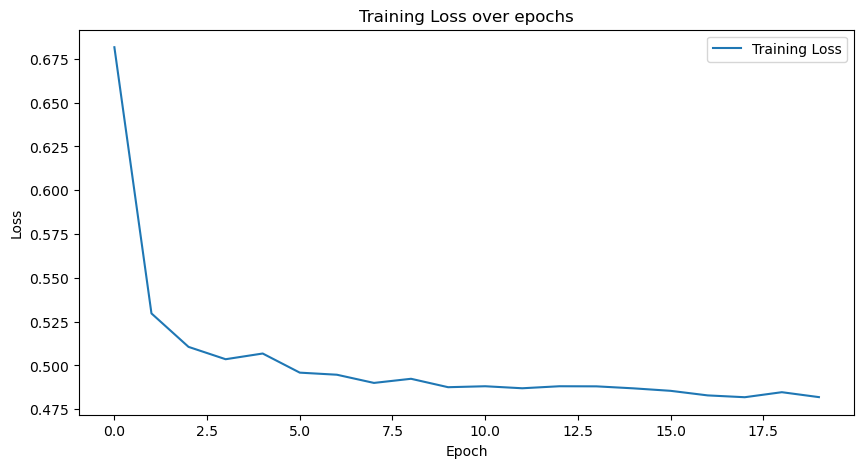

In [134]:
# plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), loss_prog, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.legend()
plt.show()

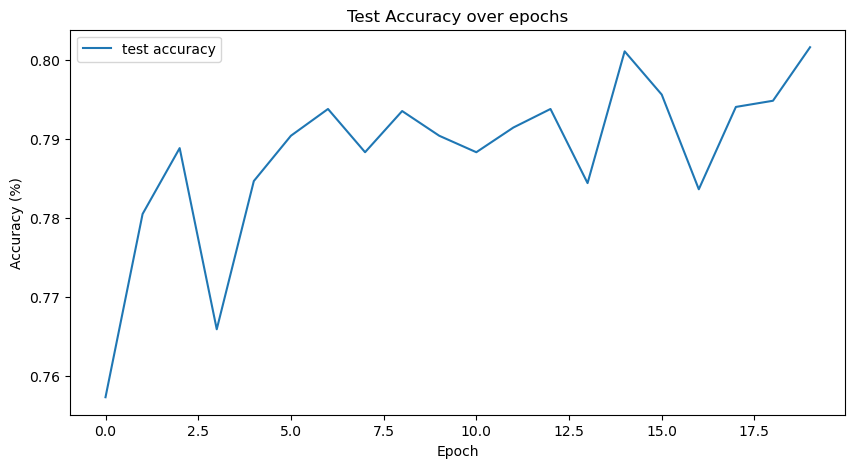

In [135]:
# plot testing accuracy
def plot_accuracy(accuracy_progress_list):
    plt.figure(figsize=(10, 5))
    for label, acc in accuracy_progress_list:
        plt.plot(range(epochs), acc, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy over epochs')
    plt.legend()
    plt.show()

plot_accuracy([('test accuracy', acc_prog)])

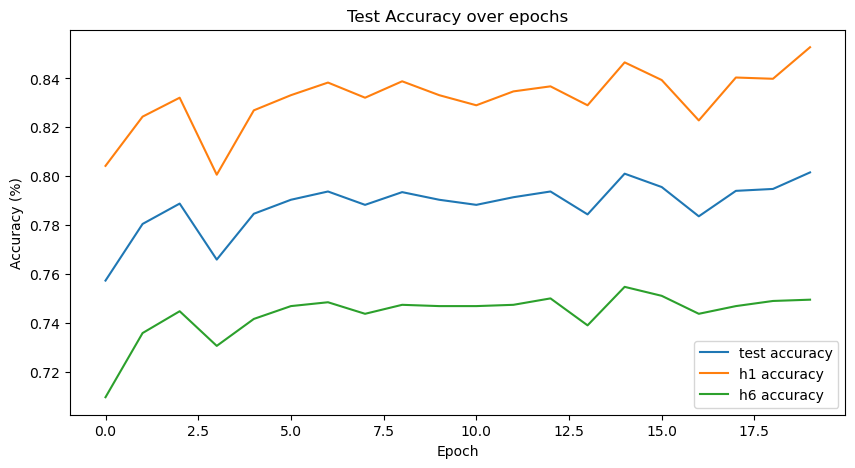

In [136]:
plot_accuracy([('test accuracy', acc_prog), ('h1 accuracy', acc_h1_prog), ('h6 accuracy', acc_h6_prog)])